imports

In [1]:
import torch
import os
import numpy as np
from tqdm import tqdm

import pandas as pd

from myhelpers import cifar_dataLoader

from HGNN.train.configParser import ConfigParser
from HGNN.train import CNN, dataLoader
from myhelpers.memory import get_cuda_memory
from myhelpers.image_show import showExample, getClosestImageFromDataloader
from myhelpers.images_tsne import get_tsne
from misc import get_classification_df

experimetnsFileName = "experiments.csv"

parameters

In [2]:
experimentsPath="/raid/elhamod/Fish/experiments/"
dataPath="/raid/elhamod/Fish/"
experimentName="Fish_scheduler_experiments"#"CIFAR_phylogeny_HGNN_lambdaExperiment"
trial_hash="5922bad3c69f629daa0af24121e292a895f308e7cae3ec4f64536186"#hier

legends=['fine', 'coarse']
use_submodel=True
plot_images=False
cuda=1
batch_size = 4
num_workers = 8

cuda

In [3]:
# set cuda
if torch.cuda.is_available():
    torch.cuda.set_device(cuda)
    print("using cuda", cuda)
    
torch.multiprocessing.set_start_method('spawn')

using cuda 1


Get dataset

In [4]:
# Get experiment parameters
experimentsFileNameAndPath = os.path.join(experimentsPath, experimetnsFileName)
if os.path.exists(experimentsFileNameAndPath):
    experiments_df = pd.read_csv(experimentsFileNameAndPath)
    experiments_df = experiments_df.where(pd.notnull(experiments_df), None)
else:
    raise Exception("Experiment not " + trial_hash + " found!")
experimentRecord = experiments_df[experiments_df["trialHash"] == trial_hash]
experiment_params = experimentRecord.to_dict('records')[0]
print(experiment_params)

config_parser = ConfigParser(experimentsPath, dataPath, experimentName)
experimentPathAndName = os.path.join(experimentsPath, experimentName)
if experiment_params['image_path'] == 'cifar-100-python':
    datasetManager = cifar_dataLoader.datasetManager(experimentPathAndName, dataPath)
else:
    datasetManager = dataLoader.datasetManager(experimentPathAndName, dataPath)
datasetManager.updateParams(config_parser.fixPaths(experiment_params))
train_loader, validation_loader, test_loader = datasetManager.getLoaders()

dataloader = torch.utils.data.DataLoader(test_loader.dataset, pin_memory=True, batch_size=batch_size, num_workers=num_workers)
dataset = dataloader.dataset

{'experimentName': 'Fish_scheduler_experiments', 'modelName': 'models/5922bad3c69f629daa0af24121e292a895f308e7cae3ec4f64536186', 'datasetName': 'datasplits/7c7513bdfb4e5577fef1c3ec0fa6452d30d87dbc95f258a7c86dd76b', 'experimentHash': 'd76671f30f9c5b1773e7c876f09f3c399e6e6f05d785b8dcb5023857', 'trialHash': '5922bad3c69f629daa0af24121e292a895f308e7cae3ec4f64536186', 'image_path': 'Curated4/Easy_50', 'suffix': None, 'img_res': 448, 'augmented': True, 'batchSize': 64, 'learning_rate': 0.001, 'numOfTrials': 1, 'fc_layers': 1, 'modelType': 'BB', 'lambda': 0.0, 'unsupervisedOnTest': None, 'tl_model': 'ResNet18', 'link_layer': 'avgpool', 'adaptive_smoothing': True, 'adaptive_lambda': 0.1, 'adaptive_alpha': 0.5, 'noSpeciesBackprop': False, 'phylogeny_loss': 'False', 'phylogeny_loss_epsilon': 0.03, 'tripletEnabled': True, 'tripletSamples': 2.0, 'tripletSelector': 'semihard', 'tripletMargin': 2.0, 'displayName': 'Fish-s-triplet-hier-gamma0.5', 'pretrained': True, 'epochs': 40.0, 'patience': -1.0, 

Get untrained model

In [5]:
%%capture

architecture = {
    "fine": len(dataset.csv_processor.getFineList()),
    "coarse" : len(dataset.csv_processor.getCoarseList())
}
model = CNN.create_model(architecture, experiment_params, cuda)

# get the model and the parameters
modelName = experimentRecord.iloc[0]["modelName"]
trialName = os.path.join(experimentPathAndName, modelName)
_ = CNN.loadModel(model, trialName)
model.eval()

Show example and closest images

Show TSNE

100%|██████████| 95/95 [00:08<00:00, 10.66it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 380 samples in 0.002s...
[t-SNE] Computed neighbors for 380 samples in 0.030s...
[t-SNE] Computed conditional probabilities for sample 380 / 380
[t-SNE] Mean sigma: 37.237324
[t-SNE] Computed conditional probabilities in 0.030s
[t-SNE] Iteration 50: error = 70.6674042, gradient norm = 0.5661787 (50 iterations in 0.491s)
[t-SNE] Iteration 100: error = 69.8202133, gradient norm = 0.5639534 (50 iterations in 0.525s)
[t-SNE] Iteration 150: error = 73.5880814, gradient norm = 0.5254461 (50 iterations in 0.106s)
[t-SNE] Iteration 200: error = 70.7456207, gradient norm = 0.5721509 (50 iterations in 3.649s)
[t-SNE] Iteration 250: error = 72.3655014, gradient norm = 0.5361540 (50 iterations in 4.851s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.365501
[t-SNE] Iteration 300: error = 0.9636315, gradient norm = 0.0046224 (50 iterations in 4.605s)
[t-SNE] Iteration 350: error = 0.7973222, gradient norm = 0.0019979 

100%|██████████| 95/95 [00:06<00:00, 15.57it/s]


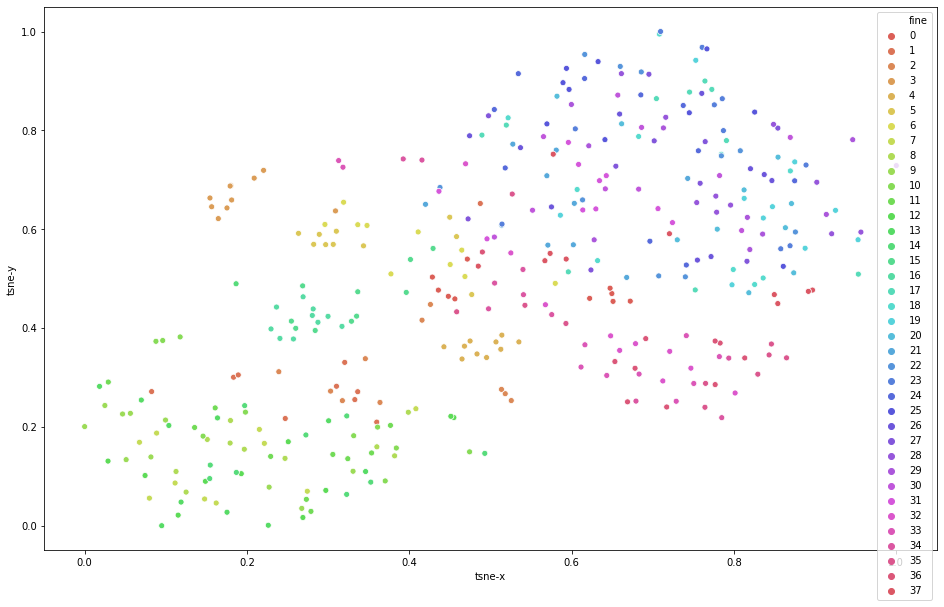

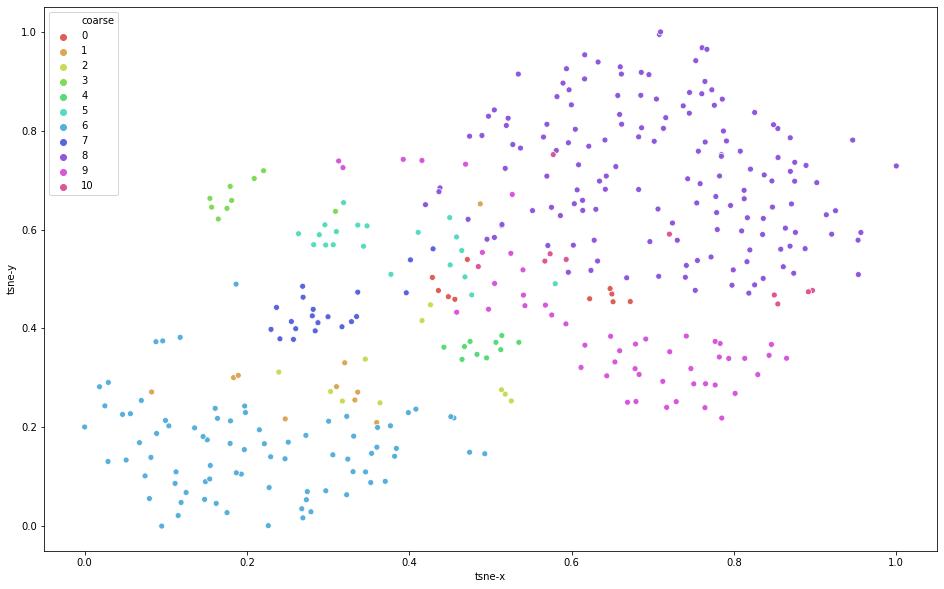

In [6]:
activation_layer = 'layer2'#'fine'

model_sub = model
if hasattr(model, 'network_fine') and use_submodel==True:
    model_sub = model.network_fine

get_tsne(dataloader, model_sub, activation_layer, experiment_params['img_res'], 
                os.path.join(experimentPathAndName, modelName), 
                "test_"+activation_layer+("_submodule" if use_submodel==True else ""), legends, plot_images, cuda)

100%|██████████| 95/95 [00:08<00:00, 11.72it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 380 samples in 0.004s...
[t-SNE] Computed neighbors for 380 samples in 0.040s...
[t-SNE] Computed conditional probabilities for sample 380 / 380
[t-SNE] Mean sigma: 92.515729
[t-SNE] Computed conditional probabilities in 0.040s
[t-SNE] Iteration 50: error = 63.9725723, gradient norm = 0.5682989 (50 iterations in 0.237s)
[t-SNE] Iteration 100: error = 64.3047409, gradient norm = 0.5444056 (50 iterations in 0.098s)
[t-SNE] Iteration 150: error = 64.0961075, gradient norm = 0.5446562 (50 iterations in 0.043s)
[t-SNE] Iteration 200: error = 64.0940933, gradient norm = 0.5462441 (50 iterations in 0.060s)
[t-SNE] Iteration 250: error = 63.1968880, gradient norm = 0.5814595 (50 iterations in 0.053s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.196888
[t-SNE] Iteration 300: error = 0.4384536, gradient norm = 0.0131021 (50 iterations in 0.040s)
[t-SNE] Iteration 350: error = 0.3863274, gradient norm = 0.0014293 

100%|██████████| 95/95 [00:06<00:00, 15.41it/s]


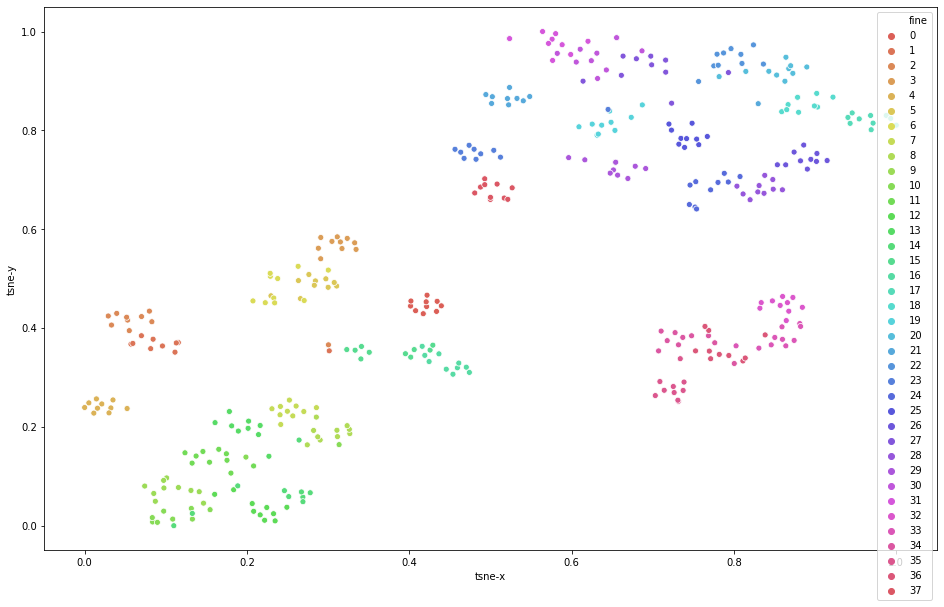

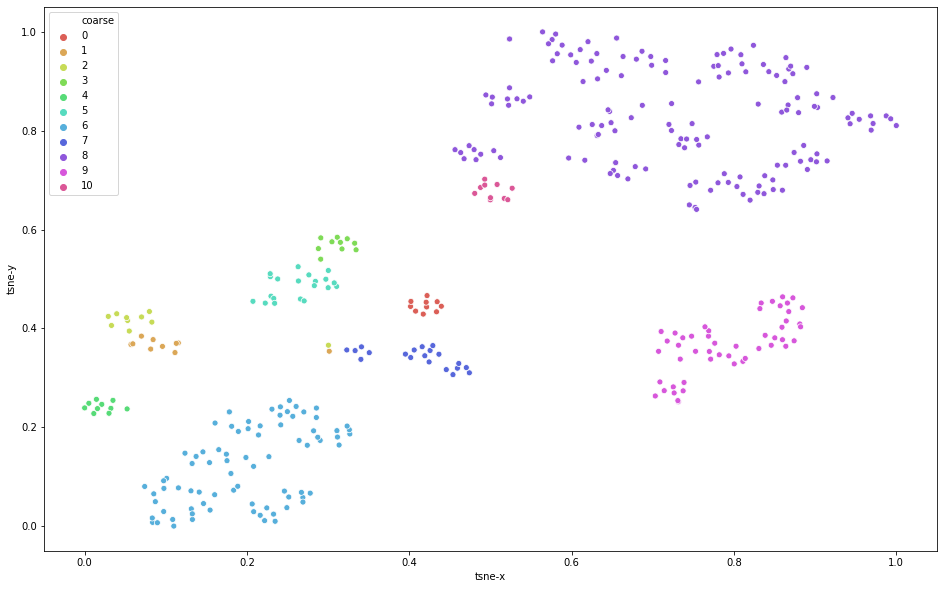

In [7]:
activation_layer = 'layer4'#'fine'

get_tsne(dataloader, model_sub, activation_layer, experiment_params['img_res'], 
                os.path.join(experimentPathAndName, modelName), 
                "test_"+activation_layer+("_submodule" if use_submodel==True else ""), legends, plot_images, cuda)

100%|██████████| 95/95 [00:06<00:00, 14.23it/s]


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 380 samples in 0.002s...
[t-SNE] Computed neighbors for 380 samples in 0.021s...
[t-SNE] Computed conditional probabilities for sample 380 / 380
[t-SNE] Mean sigma: 5.041567
[t-SNE] Computed conditional probabilities in 0.023s
[t-SNE] Iteration 50: error = 57.5671158, gradient norm = 0.5942492 (50 iterations in 0.397s)
[t-SNE] Iteration 100: error = 56.6347733, gradient norm = 0.5946434 (50 iterations in 0.053s)
[t-SNE] Iteration 150: error = 56.8136101, gradient norm = 0.5862294 (50 iterations in 0.040s)
[t-SNE] Iteration 200: error = 56.1789894, gradient norm = 0.5968949 (50 iterations in 0.210s)
[t-SNE] Iteration 250: error = 57.5926781, gradient norm = 0.5671523 (50 iterations in 1.168s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.592678
[t-SNE] Iteration 300: error = 0.3040798, gradient norm = 0.0014562 (50 iterations in 0.195s)
[t-SNE] Iteration 350: error = 0.2704119, gradient norm = 0.0003571 (

100%|██████████| 95/95 [00:06<00:00, 15.81it/s]


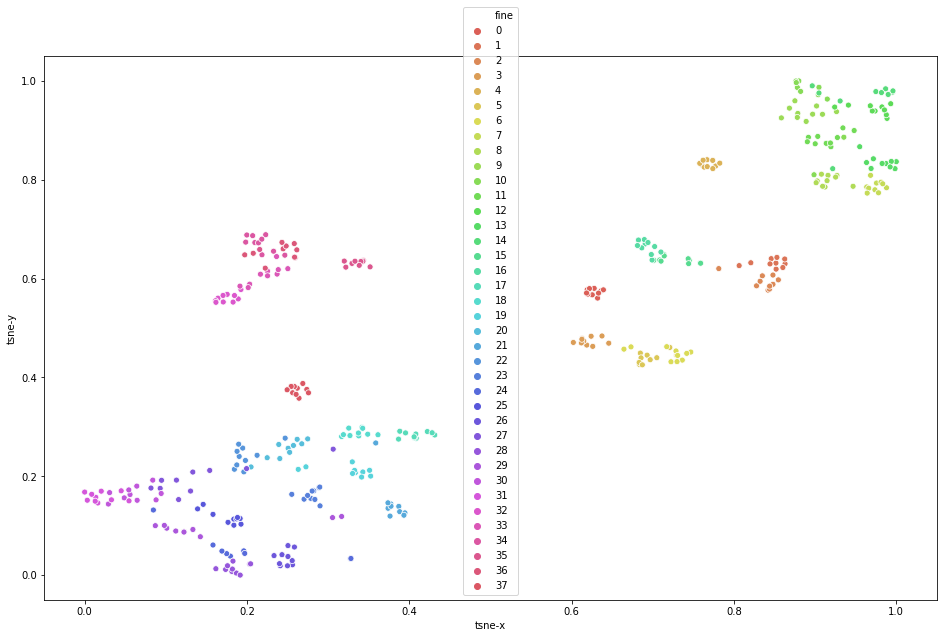

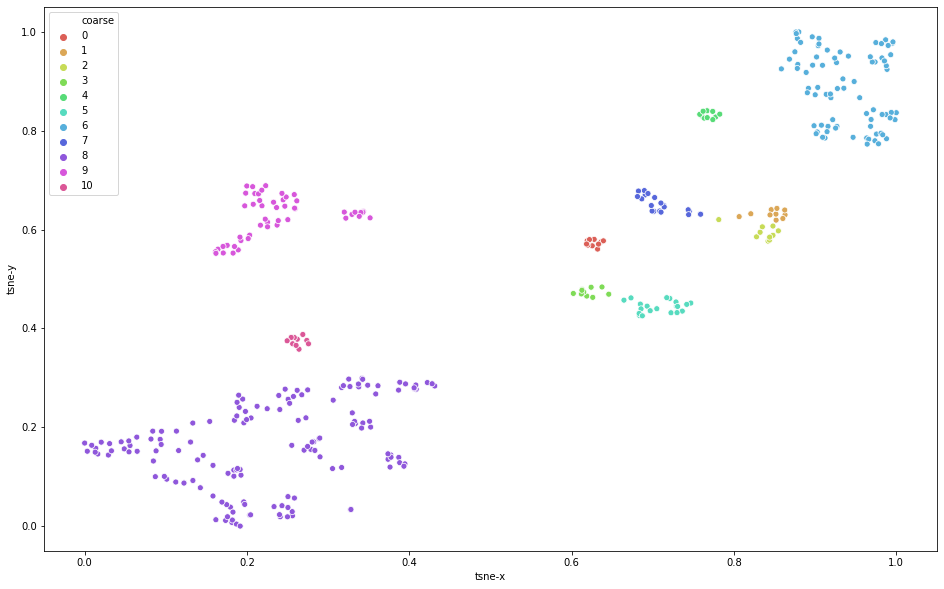

In [8]:
activation_layer = 'fine'#'fine'

get_tsne(dataloader, model_sub, activation_layer, experiment_params['img_res'], 
                os.path.join(experimentPathAndName, modelName), 
                "test_"+activation_layer+("_submodule" if use_submodel==True else ""), legends, plot_images, cuda)